The [Heliophysics Application Programmer’s Interface (HAPI)](http://hapi-server.org/) data access specification is a RESTful API and streaming format specification for delivering digital time series data.

The first part of this walkthrough has 5 parts:
* [HAPI_01.ipynb - First look at HAPI](HAPI_01.ipynb) (this Notebook)
* [HAPI_02.ipynb - Data structures](HAPI_02.ipynb)
* [HAPI_03.ipynb - Plotting, Pandas, and metadata](HAPI_03.ipynb)
* [HAPI_04.ipynb - Data fusion using HAPI](HAPI_04.ipynb)
* [HAPI_05.ipynb - The HAPI ecosystem](HAPI_05.ipynb)

HAPI serves time series data in a mission-independent format as a single continous dataset (regardless of mission file formats or file boundaries) from any mission that has implemented a HAPI server.

This notebook demonstrates the features of a Python client that accesses data from HAPI-compliant data servers. Home users can optionally [install this notebook locally](HAPI_install.ipynb).

For more information on HAPI-related software, see http://hapi-server.org/.

# Setup
We'll be using examples from the October 28 2022 flare + CME event that started at 15:35 UTC and explore it from a variety of instruments.
  
First we will import the HAPI libraries.  We'll repeat these calls in each example  so that you can try them in any order during this demo.  The basic import lines can be used in any Python code.  We also turn off some warnings (for socket connections) that clutter up the Notebook enviroment specifically (see https://github.com/boto/boto3/issues/454 for nuances on why.)

In [10]:
from hapiclient import hapi
from hapiplot import hapiplot
%matplotlib inline 
%config InlineBackend.figure_formats = ['svg']
# Show plots in page instead of opening a window
import warnings
warnings.simplefilter("ignore", ResourceWarning) # removes spurious Notebook warns

# Display documentation
A quick look at what built-in documentation the hapi client provides:

In [2]:
help(hapi)

Help on function hapi in module hapiclient.hapi:

hapi(*args, **kwargs)
    Request data from a HAPI server.
    
    Version: 0.2.2
    
    
    Examples
    ----------
    `Jupyter Notebook <https://colab.research.google.com/drive/11Zy99koiE90JKJ4u_KPTaEBMQFzbfU3P?usp=sharing>_`
    
    Parameters
    ----------
    server : str
        A string with the URL to a HAPI compliant server. (A HAPI URL
        always ends with "/hapi").
    dataset : str
        A string specifying a dataset from a `server`
    parameters: str
        A Comma-separated list of parameters in `dataset`
    start: str
        The start time of the requested data
    stop: str
        The end time of the requested data; end times are exclusive - the
        last data record returned by a HAPI server should have a timestamp
        before `start`.
    options : dict
    
            `logging` (False) - Log to console
    
            `cache` (True) - Save responses and processed responses in cachedir
    
  

# October 2021 event.
The event started at 15:35UTC on Oct 28, 2022 with a [X1 Flare](https://www.spaceweatherlive.com/en/news/view/445/20211028-x1-solar-flare-with-a-major-cme.html) and an accompanying coronal mass ejection (CME). The CME was predicted to arrive [at Earth on Oct 30](https://www.swpc.noaa.gov/news/geomagnetic-storm-watch-effect-30-31-oct) and induce activity through Oct 31.  We will look at data fetched via HAPI for before, during, and after this event and see what patterns arise.

Instruments we'll use to start this demo include

* Solar Wind compiled data using [OMNI](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018SW002113)

* Measurements [at L1](https://helionauts.org/t/ace-and-dscovr-data-types/389/8) (e.g. ACE, DISCOVR, WIND, ISEE-3), we'll use DSCOVER H0 mag and H1 plasma data from CDAWeb

* Near Earth (ISEE-1, IMP-8, Geotail, Cluster)

* Measurement from Earth: "The Kp index is a measure of the disturbance of the geomagnetic field measured at Earth’s
surface. The scale ranges from 0 to 9 with no units. A Kp of 3 or less is considered undisturbed,
a Kp greater than 4 is considered storm conditions."

During these examples, you'll also be offered a menu of other potential instruments to add in, including: 

## Example 1: OMNIWeb Solar Wind via CDAWeb
We will start by using HAPI to fetch OMNIWeb solar wind `DST1800` data (1-hour Dst index) and `Proton_AI1800` (Solar wind mag density/kinetic energy density), plus metadata, for Oct 25 through Dec 5.  For this first example, we are setting `logging=True` so you can see what steps HAPI is (or is not) doing; for production use or to de-clutter the screen, you likely will choose to turn this off with `logging=False`.

_Note HAPI returns data as a NumPy array_

In [2]:
## OMNIWeb data
from hapiclient import hapi
from hapiplot import hapiplot
from hapiclient.util import pythonshell
%matplotlib inline 

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'OMNI2_H0_MRG1HR' # See section 5 for information on finding list of datasets
start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
parameters = 'DST1800,Proton_QI1800' # See section 5 for information on finding parameters in dataset
opts       = {'logging': True, 'usecache': False}

# Get parameter data. See section 5 for for information on getting available datasets and parameters
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

hapi(): Running hapi.py version 0.2.2
hapi(): file directory = /tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading https://cdaweb.gsfc.nasa.gov/hapi/info?id=OMNI2_H0_MRG1HR
hapi(): Writing OMNI2_H0_MRG1HR___.json 
hapi(): Writing OMNI2_H0_MRG1HR___.pkl 
hapi(): Reading https://cdaweb.gsfc.nasa.gov/hapi/capabilities
hapi(): Writing https://cdaweb.gsfc.nasa.gov/hapi/data?id=OMNI2_H0_MRG1HR&parameters=DST1800,Proton_QI1800&time.min=2021-11-25T00:00:00Z&time.max=2021-12-05T00:00:00Z&format=binary to OMNI2_H0_MRG1HR_DST1800-Proton_QI1800_20211125T000000_20211205T000000.bin
hapi(): Reading and parsing OMNI2_H0_MRG1HR_DST1800-Proton_QI1800_20211125T000000_20211205T000000.bin
hapi(): Writing /tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi/OMNI2_H0_MRG1HR_DST1800-Proton_QI1800_20211125T000000_20211205T000000.pkl
hapi(): Writing /tmp/hapi-data/cdaweb.gsfc.nasa.gov_hapi/OMNI2_H0_MRG1HR_DST1800-Proton_QI1800_20211125T000000_20211205T000000.npy


### First we'll plot the data (using the built-in 'hapiplot' library, for now).

We would expect to see some activity in the Oct 30-31 frame, as the CME reaches L1.

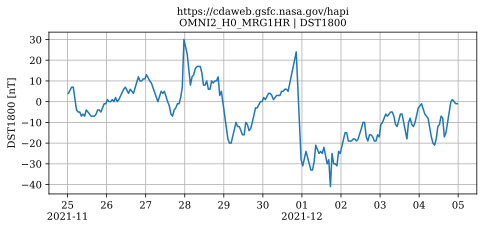

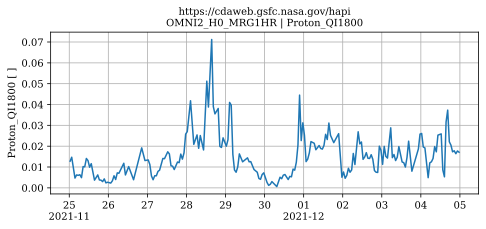

In [3]:
# Plot all parameters in data. See also section 4 for information
# on using other plotting functions, e.g., Matplotlib
status=hapiplot(data, meta)

### Also, let's look at the stored metadata HAPI provided
The metadata is essential to track and recall what we are actually looking at.  Let's see what that data structure looks like for HAPI.

In [5]:
# Print meta using display() function if using IPython or Jupyter Notebook
print(meta) if pythonshell() == 'python' else display(meta)

{'HAPI': '2.0',
 'status': {'code': 1200, 'message': 'OK'},
 'parameters': [{'name': 'Time',
   'type': 'isotime',
   'units': 'UTC',
   'length': 24,
   'fill': None},
  {'name': 'DST1800',
   'type': 'integer',
   'units': 'nT',
   'fill': '99999',
   'description': 'Dst - 1-hour Dst index (1963/001-2014/366), Provisional Dst (2015/001-2017/366), Quick-look Dst (2018/001-2022/094), from WDC Kyoto',
   'hapiplot': {'figure': <Figure size 1008x432 with 1 Axes>}},
  {'name': 'Proton_QI1800',
   'type': 'double',
   'units': ' ',
   'fill': '9.9999',
   'description': 'Solar wind (magnetic energy density)/(kinetic energy density)',
   'hapiplot': {'figure': <Figure size 1008x432 with 1 Axes>}}],
 'startDate': '1970-01-01T00:00:00Z',
 'stopDate': '2022-04-05T13:00:00Z',
 'resourceURL': 'https://cdaweb.gsfc.nasa.gov/misc/NotesO.html#OMNI2_H0_MRG1HR',
 'contact': 'J.H. King, N. Papitashvili @ ADNET, NASA GSFC',
 'x_server': 'https://cdaweb.gsfc.nasa.gov/hapi',
 'x_dataset': 'OMNI2_H0_MRG1HR

### Optionally, extract dates + one data item
Here is how to convert the HAPI timestamps into a python 'datetime' object, and also extract just one of the data parameters as a Numpy array.  We will print out the first five elements to verify this.

In [6]:
# Extract time values as datetime objects. See section 3 for more details.
from hapiclient import hapitime2datetime

dateTimes = hapitime2datetime(data['Time'])
print("\n1st 5 dateTimes = ")
print(dateTimes[0:5]) if pythonshell() == 'python' else display(dateTimes[0:5])

# Extract one of the parameters as NumPy array
BGSEc = data['DST1800']
print("\nDST1800 =")
print(BGSEc[0:5]) if pythonshell() == 'python' else display(BGSEc[0:5])



1st 5 dateTimes = 


array([datetime.datetime(2021, 11, 25, 0, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 1, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 2, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 3, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 4, 30, tzinfo=<UTC>)], dtype=object)


DST1800 =


array([4, 6, 7, 7, 0], dtype=int32)

We also can look or access the metadata of what was plotted directly, via the return value we called 'status':

In [6]:
print(status) if pythonshell() == 'python' else display(status)

{'HAPI': '2.0',
 'status': {'code': 1200, 'message': 'OK'},
 'parameters': [{'name': 'Time',
   'type': 'isotime',
   'units': 'UTC',
   'length': 24,
   'fill': None},
  {'name': 'DST1800',
   'type': 'integer',
   'units': 'nT',
   'fill': '99999',
   'description': 'Dst - 1-hour Dst index (1963/001-2014/366), Provisional Dst (2015/001-2017/366), Quick-look Dst (2018/001-2022/094), from WDC Kyoto',
   'hapiplot': {'figure': <Figure size 1008x432 with 1 Axes>}},
  {'name': 'Proton_QI1800',
   'type': 'double',
   'units': ' ',
   'fill': '9.9999',
   'description': 'Solar wind (magnetic energy density)/(kinetic energy density)',
   'hapiplot': {'figure': <Figure size 1008x432 with 1 Axes>}}],
 'startDate': '1970-01-01T00:00:00Z',
 'stopDate': '2022-04-05T13:00:00Z',
 'resourceURL': 'https://cdaweb.gsfc.nasa.gov/misc/NotesO.html#OMNI2_H0_MRG1HR',
 'contact': 'J.H. King, N. Papitashvili @ ADNET, NASA GSFC',
 'x_server': 'https://cdaweb.gsfc.nasa.gov/hapi',
 'x_dataset': 'OMNI2_H0_MRG1HR

## Example 2: DSCOVR magnetic field measurement

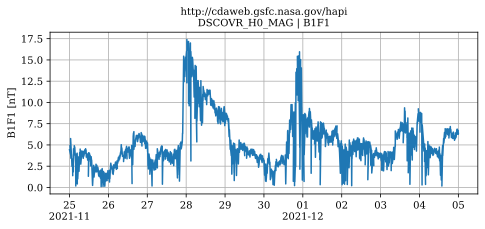

In [7]:
from hapiclient import hapi
from hapiplot import hapiplot

server     = 'http://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'DSCOVR_H0_MAG'
start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
parameters = 'B1F1'
opts       = {'logging': False, 'usecache': False}

# Get parameter data. See section 5 for for information on getting available datasets and parameters
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

# Plot all parameters. See section 3 and 4 for information
# on extracting data and using other plotting functions.
status = hapiplot(data, meta) #,**popts)


## Where is DSCOVR, anyway?
Often it is useful to know where a given spacecraft is. Coordinates are often available as a HAPI stream.  Here we get the DSCOVR position in GSE coordinates. And, for fun, the Moon's position as well. 

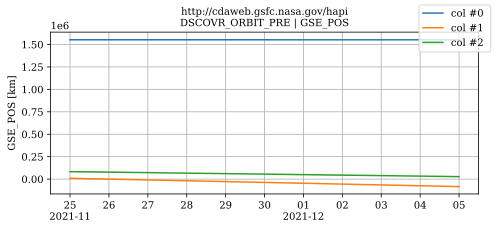

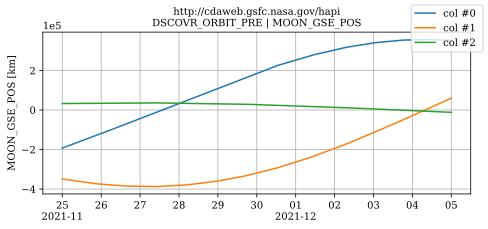

In [8]:
# note we are using the same times etc from previous calls
dataset    = 'DSCOVR_ORBIT_PRE'
parameters = 'GSE_POS,MOON_GSE_POS'

data, meta = hapi(server, dataset, parameters, start, stop, **opts)
status=hapiplot(data, meta)

### Parameter Order is Important!
To ensure that every HAPI query is identical, parameters MUST be requested in the order that their HAPI server's JSON description specifies.  For example, we queried for "GSE_POS, MOON_GSE_POS". If we switch the query order, we get a HAPI warning to correct that, as shown below. 

In [10]:
#parameters = 'GSE_POS,MOON_GSE_POS'
parameters = 'MOON_GSE_POS,GSE_POS'
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

HAPIError: Order of requested parameters does not match order of parameters in server info metadata.
  Order requested: MOON_GSE_POS,GSE_POS
  Order required: GSE_POS,MOON_GSE_POS


Fortunately, as you can see above, the HAPI warning messages aim to be informative.

----
Next up, a look into the underlying data structures in [HAPI_02.ipynb](HAPI_02.ipynb)
----